# TABLE OF CONTENTS

* [1. SETUP](#section-one)
    - [1.1 Importing Libraries](#subsection-one-one)
    - [1.2 Importing train and test datasets](#subsection-one-two)
    - [1.3 Data cleaning](#subsection-one-three)
    - [1.4 Classifying Review Sentiment](#subsection-one-four)
    - [1.5 Text Preprocessing](#subsection-one-five)


* [2. MODEL TRAINING AND TESTING](#section-two)
    - [2.1 Linear Support Vector Classifier](#subsection-two-one)
    - [2.2 Logistic Regression Classifier](#subsection-two-two)
    - [2.3 Naive Bayes Classifier](#subsection-two-three)
    - [2.4 Decision Tree Classifier](#subsection-two-four)
    - [2.5 Random Forest Classifier](#subsection-two-five)
    - [2.6 Extreme Gradient Boosting (XGBoost) Classifier](#subsection-two-six)


* [3. MODEL EVALUATION](#section-three)
    - [3.1 ROC and AUC](#subsection-three-one)
    - [3.2 Confusion Matrix](#subsection-three-two)
    - [3.3 Classification reports and accuracy score](#subsection-three-three)
    - [3.4 Comparing Feature Importance](#subsection-three-four)

<a id="section-one"></a>
# 1. SETUP

<a id="subsection-one-one"></a>
## 1.1 Importing Libraries

Execute the following script to import the required libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import missingno as msno

from sklearn.datasets import load_files
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

<a id="subsection-one-two"></a>
## 1.2 Importing train and test datasets

I will use the read_csv function from the pandas library to import the dataset.

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [3]:
train_data.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image_x
0,4.0,False,"05 1, 2018",A33YZNZIRA3H97,B005CPRM72,l2,This is a nice mild evening tea. I use 3 table...,nice mild evening tea,1525132800,NaN,"{'Size:': ' Tin', 'Flavor:': ' Nutty Almond Cr...",NaN
1,5.0,True,"05 24, 2018",A8NFILNZNLW1I,B0052OP0QS,ETW2,I bake a whole grain sourdough bread that uses...,"This flour is excellent, and considerably less...",1527120000,NaN,NaN,NaN
2,5.0,True,"06 23, 2015",A2SOXIW5GKI64E,B00I5MYZ38,Mom,XyliChew is the best Xylitol gum on the market...,"Refreshing, not too sweet, good consistency",1435017600,5.0,NaN,NaN
3,4.0,True,"03 24, 2016",A2D5Q86UIBONYR,B00CCQWK6C,gramaejue,Nice product . Bought one canister of salted a...,"Fresh , and fast delivery . Don't have a Costc...",1458777600,NaN,{'Size:': ' 40 Ounce'},NaN
4,5.0,True,"03 20, 2017",A31EJ6DN536RTQ,B00016XJVK,DD Whit,What a value and great taste.,Five Stars,1489968000,NaN,{'Size:': ' 16 Ounce Bag'},NaN


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114347 entries, 0 to 114346
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         114347 non-null  float64
 1   verified        114347 non-null  bool   
 2   reviewTime      114347 non-null  object 
 3   reviewerID      114347 non-null  object 
 4   asin            114347 non-null  object 
 5   reviewerName    114332 non-null  object 
 6   reviewText      114347 non-null  object 
 7   summary         114327 non-null  object 
 8   unixReviewTime  114347 non-null  int64  
 9   vote            15811 non-null   float64
 10  style           59240 non-null   object 
 11  image_x         921 non-null     object 
dtypes: bool(1), float64(2), int64(1), object(8)
memory usage: 9.7+ MB


<a id="subsection-one-three"></a>
## 1.3 Data Cleaning
### Handling missing data

<AxesSubplot:>

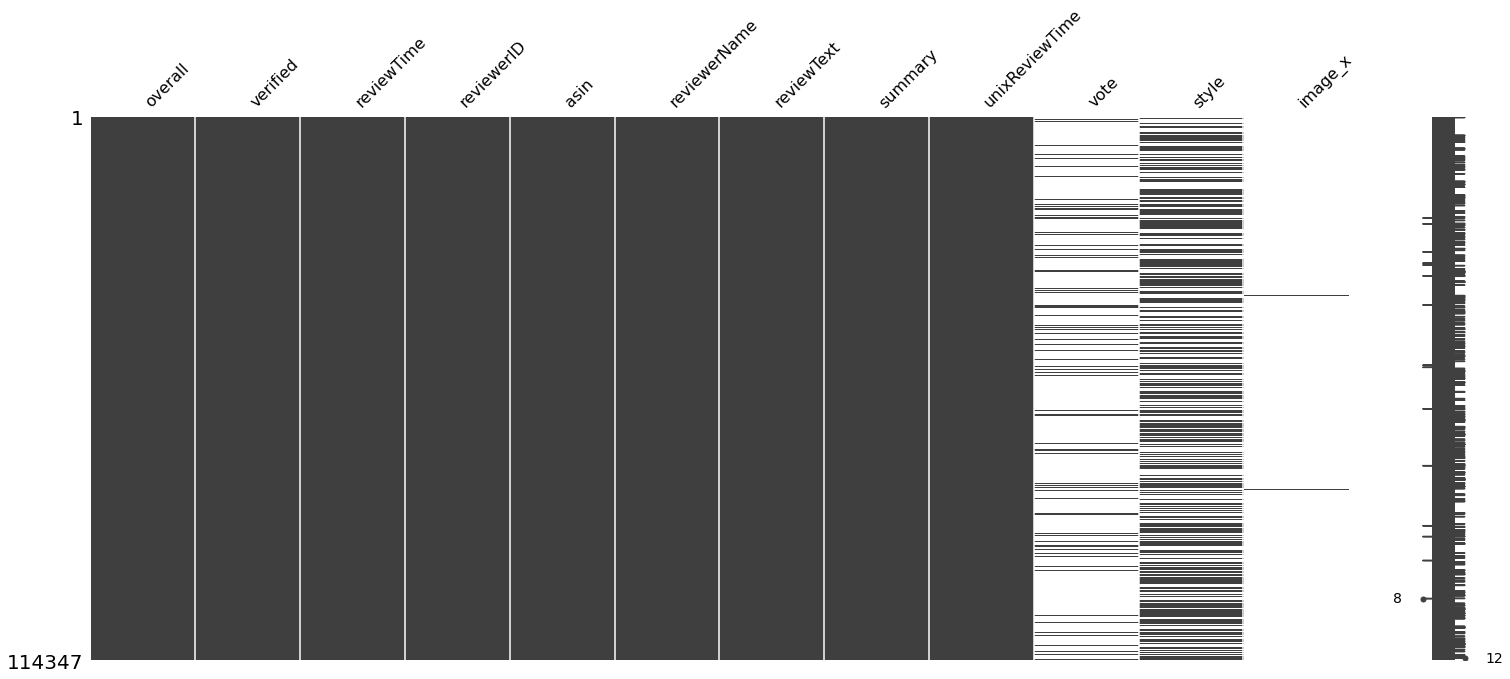

In [5]:
# Visualizing missingness of 'data_train.csv'
msno.matrix(train_data)

In [6]:
missing_train = train_data.isnull().mean().sort_values(ascending=False)
missing_train

image_x           0.991946
vote              0.861728
style             0.481928
summary           0.000175
reviewerName      0.000131
unixReviewTime    0.000000
reviewText        0.000000
asin              0.000000
reviewerID        0.000000
reviewTime        0.000000
verified          0.000000
overall           0.000000
dtype: float64

<AxesSubplot:>

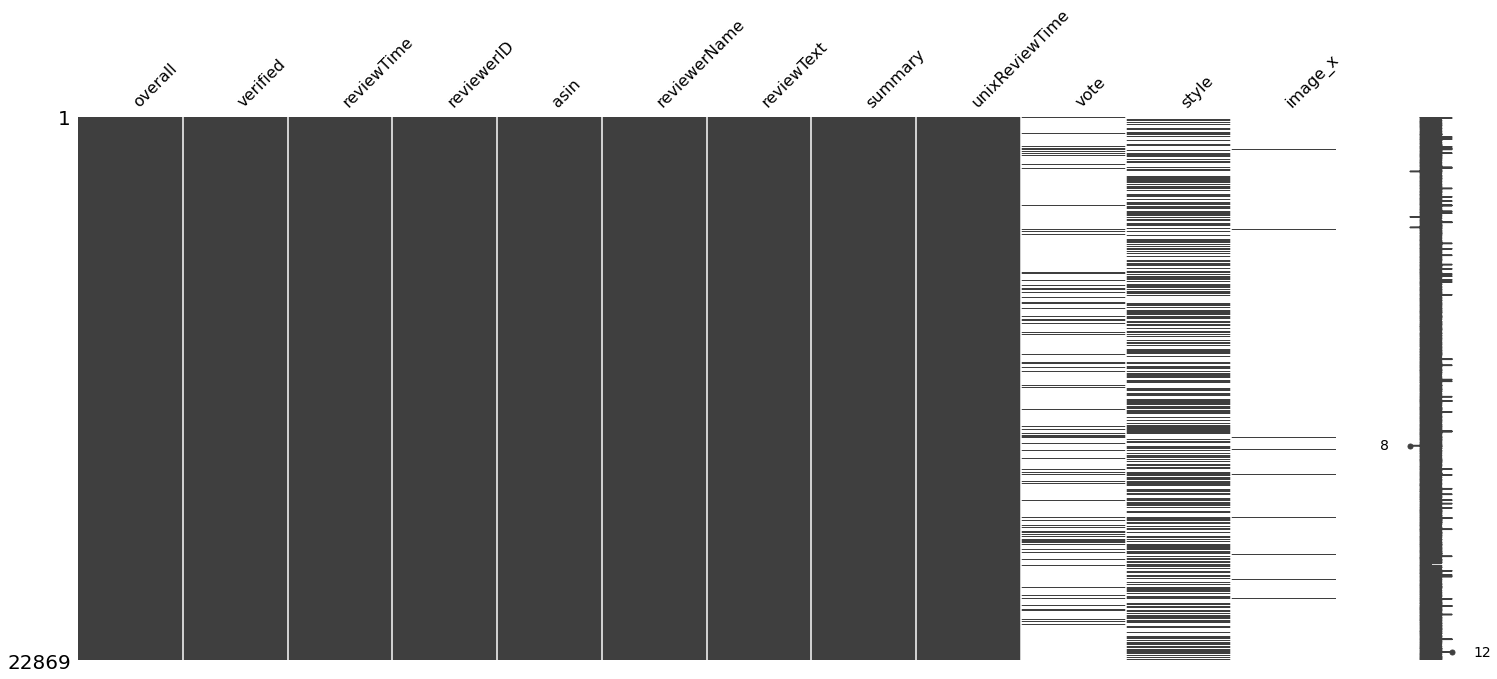

In [7]:
# Visualizing missingness of 'test.csv'
msno.matrix(test_data)

In [8]:
missing_test = test_data.isnull().mean().sort_values(ascending=False)
missing_test

image_x           0.991779
vote              0.859111
style             0.483449
summary           0.000262
reviewerName      0.000175
unixReviewTime    0.000000
reviewText        0.000000
asin              0.000000
reviewerID        0.000000
reviewTime        0.000000
verified          0.000000
overall           0.000000
dtype: float64

The train dataset contains 114,347 reviews while the test dataset contains 22,869 reviews. Both datasets are very clean and have no missing data for the two target columns for our sentiment prediction, 'reviewText' which contains the text of the review and 'overall' which contains the overall rating score from the reviewer.

However, the columns 'image_x', 'vote' and 'style' all have high percentages of missing data. As such, we will be removing these columns as they are not important to our analysis

In [9]:
drop_cols = ['image_x', 'vote', 'style']
train_data.drop(drop_cols, axis=1, inplace=True)
test_data.drop(drop_cols, axis=1, inplace=True)

<a id="subsection-one-four"></a>
## 1.4 Classifying Review Sentiment

Since we do not have a column which shows the sentiment as positive or negative in the dataset, I defined a new sentiment column. To do this, I assumed the reviews which has 4 or higher rating as positive (True in the new dataframe) and 2 or lower rating as negative (False in the new dataframe). Also, I did not include the lines that has neutral ratings which are equal to 3. 

In [10]:
# Rating of 4 or higher -> positive, while the ones with 
# Rating of 2 or lower -> negative 
# Rating of 3 -> neutral

train_data = train_data[train_data['overall'] != 3]
train_data['label'] = train_data['overall'] >=4
train_data = train_data.reset_index(drop = True)
train_data.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,label
0,4.0,False,"05 1, 2018",A33YZNZIRA3H97,B005CPRM72,l2,This is a nice mild evening tea. I use 3 table...,nice mild evening tea,1525132800,True
1,5.0,True,"05 24, 2018",A8NFILNZNLW1I,B0052OP0QS,ETW2,I bake a whole grain sourdough bread that uses...,"This flour is excellent, and considerably less...",1527120000,True
2,5.0,True,"06 23, 2015",A2SOXIW5GKI64E,B00I5MYZ38,Mom,XyliChew is the best Xylitol gum on the market...,"Refreshing, not too sweet, good consistency",1435017600,True
3,4.0,True,"03 24, 2016",A2D5Q86UIBONYR,B00CCQWK6C,gramaejue,Nice product . Bought one canister of salted a...,"Fresh , and fast delivery . Don't have a Costc...",1458777600,True
4,5.0,True,"03 20, 2017",A31EJ6DN536RTQ,B00016XJVK,DD Whit,What a value and great taste.,Five Stars,1489968000,True


In [11]:
test_data = test_data[test_data['overall'] != 3]
test_data['label'] = test_data['overall'] >=4
test_data = test_data.reset_index(drop=True)
test_data.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,label
0,5.0,True,"04 3, 2017",A3SFQQB23IZVVL,B004CH94KO,J T Cannon Jr,"Damn it, stop making these I'm diabetic.....an...",Five Stars,1491177600,True
1,5.0,True,"09 16, 2016",ABLQ6RDBAB5BG,B000NNCMG4,A. Frank,Oh- this Black Currant tea is so lovely. Very...,Perfect Black Currant Tea!,1473984000,True
2,5.0,True,"11 21, 2015",A3HQNIENJUCQMC,B0026LJRX2,lisa83,"salty,dill flavoring,delicious!!!!!!! I am tot...","salty, dill flavoring, delicious!!!! ...",1448064000,True
3,5.0,False,"01 20, 2015",A3CU0WMRHCQZ4K,B002CBXTS0,Chris,Makes the Best Tirimasu Ever!!!!!!!!\n\nSince ...,Makes the Best Tirimasu Ever,1421712000,True
4,1.0,True,"10 6, 2014",A3LS0N5ADL421D,B000MOEUNC,family adventure,Nasty. Tasted like soggy raisin bran.,gross,1412553600,False


<a id="subsection-one-five"></a>
## 1.5 Text Preprocessing

Text may contain numbers, special characters, and unwanted spaces that will complicate the training of the model. Depending upon the problem we face, we may or may not need to remove these special characters and numbers from text. However, for the sake of this assignment, I will be removing all the special characters, numbers, and unwanted spaces from our text.

In [12]:
X_train, y_train = train_data.reviewText, train_data.label
X_test, y_test = test_data.reviewText, test_data.label

In [13]:
def clean_text(data):
    stemmer = WordNetLemmatizer()
    for sen in range(0, len(data)):
        # Remove all the special characters
        doc = re.sub(r'\W', ' ', str(data[sen]))

        # remove all single characters
        doc = re.sub(r'\s+[a-zA-Z]\s+', ' ', doc)

        # Remove single characters from the start
        doc = re.sub(r'\^[a-zA-Z]\s+', ' ', doc) 

        # Substituting multiple spaces with single space
        doc = re.sub(r'\s+', ' ', doc, flags=re.I)

        # Removing prefixed 'b'
        doc = re.sub(r'^b\s+', '', doc)

        # Converting to Lowercase
        doc = doc.lower()

        docs.append(doc)

In [14]:
docs = []
clean_text(X_train)
X_train = docs

In [15]:
docs = []
clean_text(X_test)
X_test = docs

In the script above I use Regex Expressions from Python re library to perform different preprocessing tasks. 

I started by removing all non-word characters such as special characters, numbers, etc.

Next, I remove all the single characters. For instance, when we remove the punctuation mark from "Sarah's" and replace it with a space, we get "Sarah" and a single character "s", which has no meaning. To remove such single characters I used \s+[a-zA-Z]\s+ regular expression which substitutes all the single characters having spaces on either side, with a single space.

Next, we use the \^[a-zA-Z]\s+ regular expression to replace a single character from the beginning of the document, with a single space. Replacing single characters with a single space may result in multiple spaces, which is not ideal.

We again use the regular expression \s+ to replace one or more spaces with a single space. When you have a dataset in bytes format, the alphabet letter "b" is appended before every string. The regex ^b\s+ removes "b" from the start of a string. The next step is to convert the data to lower case so that the words that are actually the same but have different cases can be treated equally.

<a id="section-two"></a>
# 2. MODEL TRAINING AND TESTING

We will train and test the following classification models:
1. Linear Support Vector Classifier (SVC)
2. Logistic Regression Classifier
3. Naive Bayes Classifier
4. Decision Tree Classifier
5. Random Forest Classifier
6. Extreme Gradient Boosting (XGBoost) Classifier

### Unigram Vectorizer

In [16]:
vect = TfidfVectorizer()
pipe_svc              = Pipeline([('vect', vect), ('svc_model', CalibratedClassifierCV(LinearSVC()))])
pipe_logistic         = Pipeline([('vect', vect), ('lr_model', LogisticRegression())])
pipe_nb               = Pipeline([('vect', vect), ('nb_model', MultinomialNB())])
pipe_tree             = Pipeline([('vect', vect), ('tree_model', DecisionTreeClassifier(random_state=3618))])
pipe_forest           = Pipeline([('vect', vect), ('forest_model', RandomForestClassifier(n_estimators=1000, random_state=0))])
pipe_xgb              = Pipeline([('vect', vect), ('xgb_model', XGBClassifier())])

<a id="subsection-two-one"></a>
## 2.1 Linear Support Vector Classifier

In [17]:
model_svc = pipe_svc.fit(X_train, y_train)
y_pred_svc = model_svc.predict(X_test)

<a id="subsection-two-two"></a>
## 2.2 Logistic Regression Classifier

Second, I will be using a logistic regression Classifier from the sklearn.linear_model library.

In [18]:
model_lr = pipe_logistic.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)

<a id="subsection-two-three"></a>
## 2.3 Naive Bayes Classifier

Third, I will be using the MultinomialNB model from the sklearn.naive_bayes library.

In [19]:
model_nb = pipe_nb.fit(X_train, y_train)
y_pred_nb = model_nb.predict(X_test)

<a id="subsection-two-four"></a>
## 2.4 Decision  Tree Classifier

In [20]:
model_tree = pipe_tree.fit(X_train, y_train)
y_pred_tree = model_tree.predict(X_test)

<a id="subsection-two-five"></a>
## 2.5 Random Forest Classifier

Fifth, I will be using the Random Forest Classifier from the sklearn.ensemble library.

In [21]:
model_forest = pipe_forest.fit(X_train, y_train)
y_pred_forest = model_forest.predict(X_test)

<a id="subsection-two-six"></a>
## 2.6 Extreme Gradient Boosting (XGBoost) Classifier

Finally, I will be using the Extreme Gradient Boosting (XGBoost) Classifier from the xgboost library.

In [22]:
model_xgb = pipe_xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_test)

<a id="section-three"></a>
# 3. MODEL EVALUATION

The above models will be evaluated on on their accuracy (precision, recall, F1-measure).

Further measures such as their confusion matrix, roc curve and auc will also be used.

<a id="subsection-three-one"></a>
## 3.1 ROC and AUC

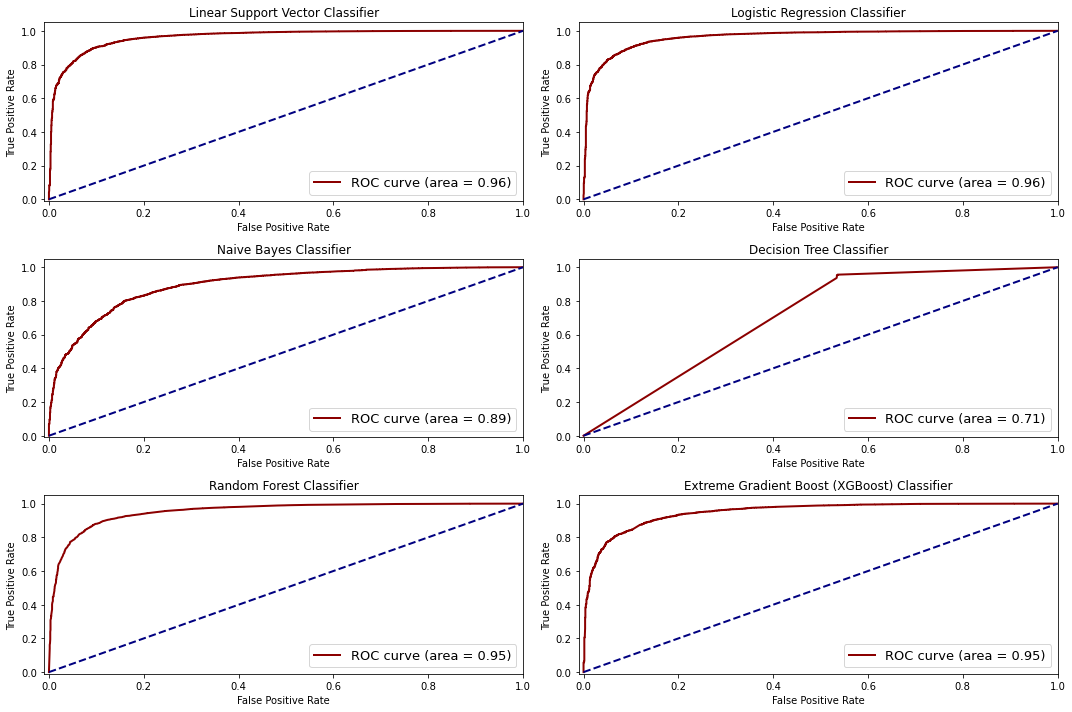

In [23]:
pred_svc = model_svc.predict_proba(X_test)[:, 1]
fpr_svc,tpr_svc,_ = roc_curve(y_test,pred_svc)
roc_auc_svc = auc(fpr_svc,tpr_svc)

pred_lr = model_lr.predict_proba(X_test)[:, 1]
fpr_lr,tpr_lr,_ = roc_curve(y_test,pred_lr)
roc_auc_lr = auc(fpr_lr,tpr_lr)

pred_mnb = model_nb.predict_proba(X_test)[:, 1]
fpr_mnb,tpr_mnb,_ = roc_curve(y_test,pred_mnb)
roc_auc_mnb = auc(fpr_mnb,tpr_mnb)

pred_tree = model_tree.predict_proba(X_test)[:, 1]
fpr_tree,tpr_tree,_ = roc_curve(y_test,pred_tree)
roc_auc_tree = auc(fpr_tree,tpr_tree)

pred_forest = model_forest.predict_proba(X_test)[:, 1]
fpr_forest,tpr_forest,_ = roc_curve(y_test,pred_forest)
roc_auc_forest = auc(fpr_forest,tpr_forest)

pred_xgb = model_xgb.predict_proba(X_test)[:, 1]
fpr_xgb,tpr_xgb,_ = roc_curve(y_test,pred_xgb)
roc_auc_xgb = auc(fpr_xgb,tpr_xgb)

f, axes = plt.subplots(3, 2,figsize=(15,10))

axes[0,0].plot(fpr_svc, tpr_svc, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_svc))
axes[0,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0,0].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[0,0].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Linear Support Vector Classifier')
axes[0,0].legend(loc='lower right', fontsize=13)

axes[0,1].plot(fpr_lr, tpr_lr, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_lr))
axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0,1].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[0,1].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Logistic Regression Classifier')
axes[0,1].legend(loc='lower right', fontsize=13)

axes[1,0].plot(fpr_mnb,tpr_mnb, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_mnb))
axes[1,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1,0].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[1,0].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Naive Bayes Classifier')
axes[1,0].legend(loc='lower right', fontsize=13)

axes[1,1].plot(fpr_tree, tpr_tree, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_tree))
axes[1,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1,1].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[1,1].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Decision Tree Classifier')
axes[1,1].legend(loc='lower right', fontsize=13)

axes[2,0].plot(fpr_forest, tpr_forest, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_forest))
axes[2,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[2,0].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[2,0].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Random Forest Classifier')
axes[2,0].legend(loc='lower right', fontsize=13)

axes[2,1].plot(fpr_xgb, tpr_xgb, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_xgb))
axes[2,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[2,1].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[2,1].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Extreme Gradient Boost (XGBoost) Classifier')
axes[2,1].legend(loc='lower right', fontsize=13);

plt.tight_layout()

I started my evaluation with ROC curve and AUC. As you may observe above, results look pretty good for all models except the decision tree. However, it does not give much insight, except indicating the rough performance of each model. To decide which model is the best, we must also examine other evaluation metrics.

<a id="subsection-three-two"></a>
## 3.2 Confusion Matrix

To reach more information, I also used confusion matrices. 

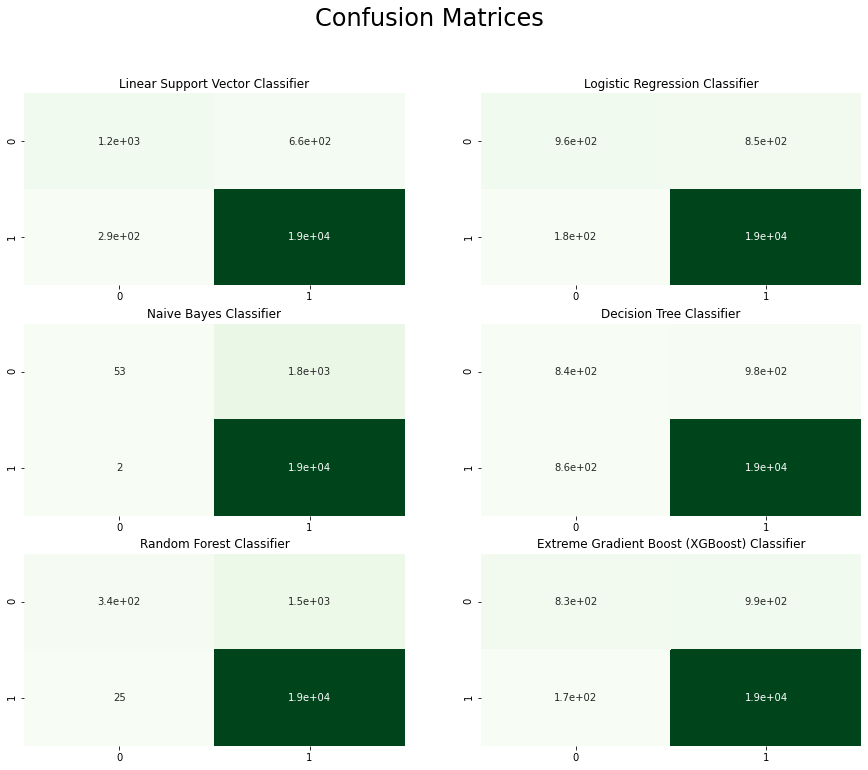

In [24]:
# preparation for the confusion matrix
svc_cm = confusion_matrix(y_test.values, y_pred_svc)
lr_cm = confusion_matrix(y_test.values, y_pred_lr)
mnb_cm = confusion_matrix(y_test.values, y_pred_nb)
tree_cm = confusion_matrix(y_test.values, y_pred_tree)
forest_cm = confusion_matrix(y_test.values, y_pred_forest)
xgb_cm = confusion_matrix(y_test.values, y_pred_xgb)

plt.figure(figsize=(15,12))
plt.suptitle("Confusion Matrices",fontsize=24)

plt.subplot(3,2,1)
plt.title("Linear Support Vector Classifier")
sns.heatmap(svc_cm, annot = True, cmap="Greens",cbar=False);

plt.subplot(3,2,2)
plt.title("Logistic Regression Classifier")
sns.heatmap(lr_cm, annot = True, cmap="Greens",cbar=False);

plt.subplot(3,2,3)
plt.title("Naive Bayes Classifier")
sns.heatmap(mnb_cm, annot = True, cmap="Greens",cbar=False);

plt.subplot(3,2,4)
plt.title("Decision Tree Classifier")
sns.heatmap(tree_cm, annot = True, cmap="Greens",cbar=False);

plt.subplot(3,2,5)
plt.title("Random Forest Classifier")
sns.heatmap(forest_cm, annot = True, cmap="Greens",cbar=False);

plt.subplot(3,2,6)
plt.title("Extreme Gradient Boost (XGBoost) Classifier")
sns.heatmap(xgb_cm, annot = True, cmap="Greens",cbar=False);

From the above confusion matrices, we get a better look at why some models are performing better than others.

<a id="subsection-three-three"></a>
## 3.3 Classification reports and accuracy score

In [158]:
print("\n\n Linear Support Vector Classifier")
print(classification_report(y_test, y_pred_svc))
print("Accuracy: {}".format(accuracy_score(y_test, y_pred_svc)))

print("\n\n Logistic Regression Classifier")
print(classification_report(y_test, y_pred_lr))
print("Accuracy: {}".format(accuracy_score(y_test, y_pred_lr)))

print("Naive Bayes Classifier")
print(classification_report(y_test, y_pred_nb))
print("Accuracy: {}".format(accuracy_score(y_test, y_pred_nb)))

print("Decision Tree Classifier")
print(classification_report(y_test, y_pred_tree))
print("Accuracy: {}".format(accuracy_score(y_test, y_pred_tree)))

print("\n\n Random Forest Classifier")
print(classification_report(y_test, y_pred_forest))
print("Accuracy: {}".format(accuracy_score(y_test, y_pred_forest)))

print("\n\n Extreme Gradient Boost (XGBoost) Classifier")
print(classification_report(y_test, y_pred_xgb))
print("Accuracy: {}".format(accuracy_score(y_test, y_pred_xgb)))



 Linear Support Vector Classifier
              precision    recall  f1-score   support

       False       0.80      0.64      0.71      1815
        True       0.97      0.99      0.98     19467

    accuracy                           0.96     21282
   macro avg       0.88      0.81      0.84     21282
weighted avg       0.95      0.96      0.95     21282

Accuracy: 0.9555962785452495


 Logistic Regression Classifier
              precision    recall  f1-score   support

       False       0.84      0.53      0.65      1815
        True       0.96      0.99      0.97     19467

    accuracy                           0.95     21282
   macro avg       0.90      0.76      0.81     21282
weighted avg       0.95      0.95      0.95     21282

Accuracy: 0.9516962691476365
Naive Bayes Classifier
              precision    recall  f1-score   support

       False       0.96      0.03      0.06      1815
        True       0.92      1.00      0.96     19467

    accuracy                   

<a id="subsection-three-four"></a>
## 3.4 Comparing Feature Importance

In [92]:
from sklearn.feature_extraction.text import CountVectorizer

In [99]:
cv = CountVectorizer()
cv.fit(X_train)
print(len(cv.vocabulary_))
print(cv.get_feature_names()[:10])

39304
['00', '000', '0000', '00000', '00096', '001', '00156', '002', '0060721855', '00703']


In [123]:
def plot_coefficients(classifier, classifier_name, feature_names, top_features=20):
    coef = classifier
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.title(classifier_name + ' Ranked Feature Importance')
    plt.show()

In [156]:
def plot_feature_importance(classifier, classifier_name, feature_names, top_features=40):
    feature_importance = classifier
    top_importance = np.argsort(feature_importance)[-top_features:]
    # create plot
    plt.figure(figsize=(15, 5))
    plt.bar(np.arange(top_features), feature_importance[top_importance], color='blue')
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(top_features), feature_names[top_importance], rotation=60, ha='right')
    plt.title(classifier_name + ' Ranked Feature Importance')
    plt.show()

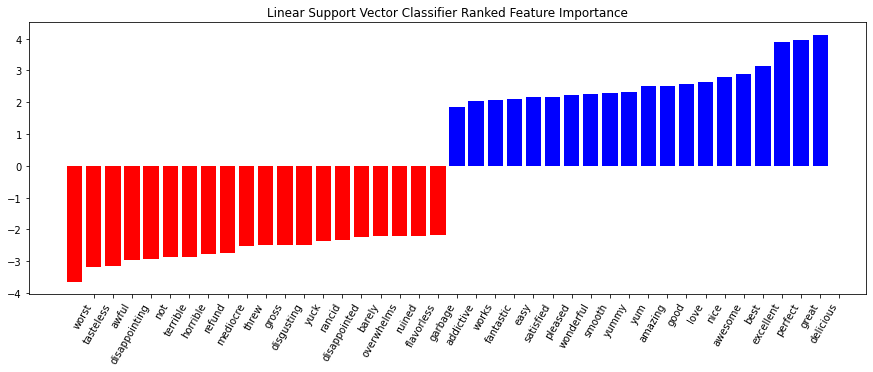

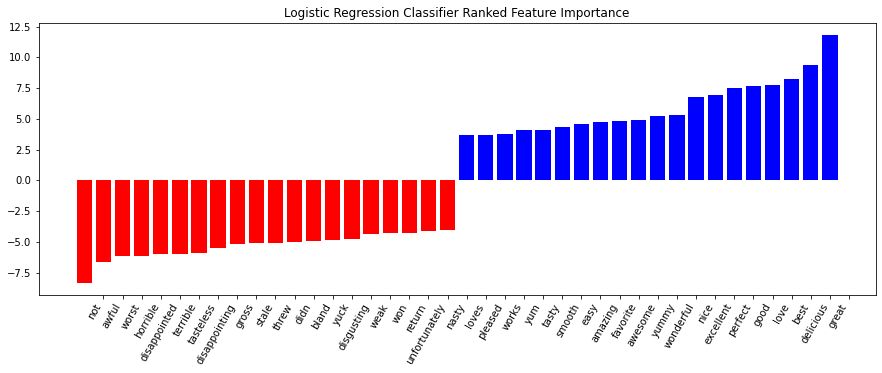

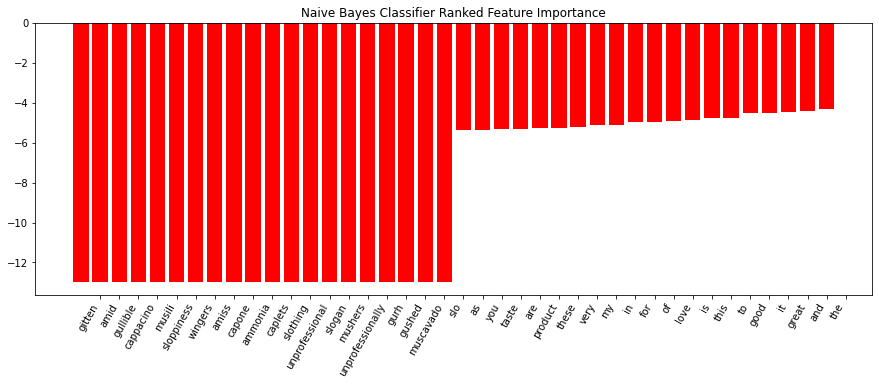

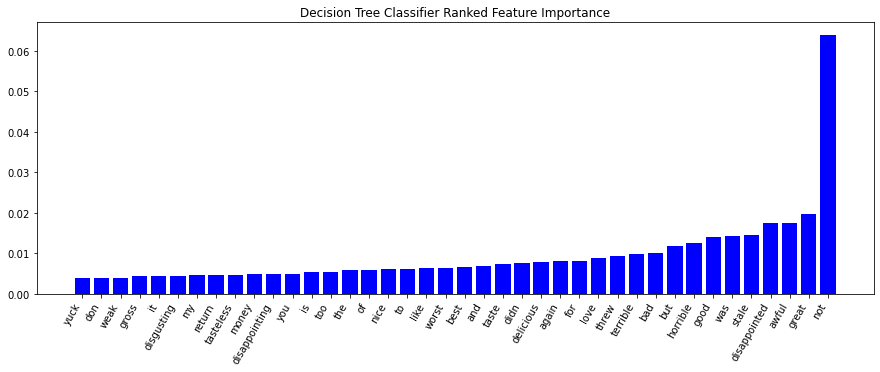

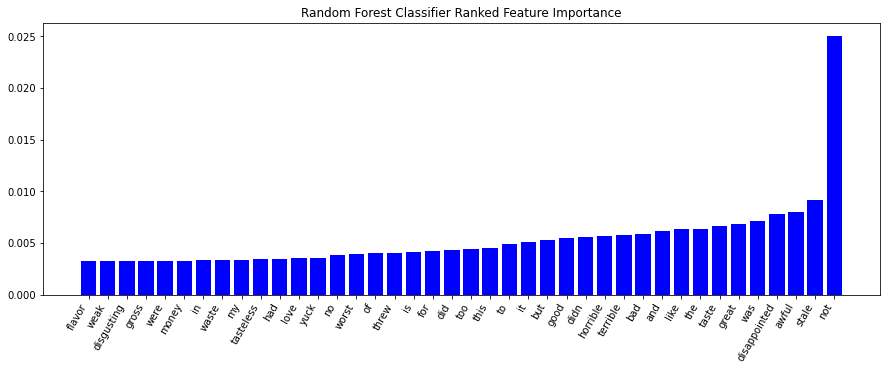

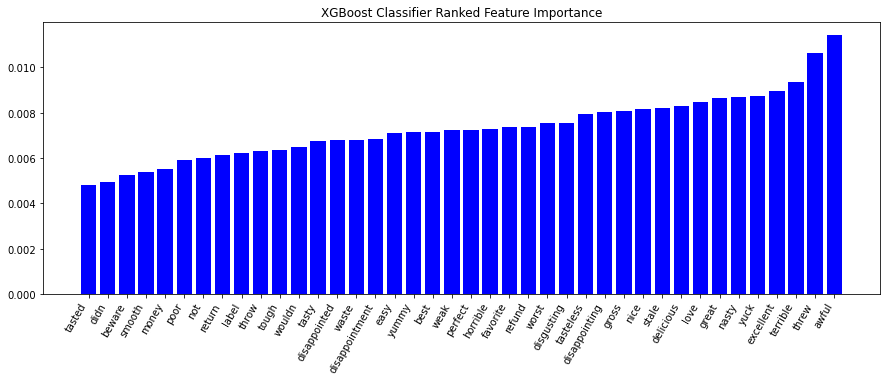

In [157]:
# get importance
coef_avg = 0
for i in pipe_svc['svc_model'].calibrated_classifiers_:
    coef_avg = coef_avg + i.base_estimator.coef_
importance_svc  = coef_avg/len(pipe_svc['svc_model'].calibrated_classifiers_)
importance_svc = importance_svc[0]
importance_lr = pipe_logistic['lr_model'].coef_[0]
importance_nb = pipe_nb['nb_model'].coef_[0]
importance_tree = pipe_tree['tree_model'].feature_importances_
importance_forest = pipe_forest['forest_model'].feature_importances_
importance_xgb = pipe_xgb['xgb_model'].feature_importances_

plot_coefficients(importance_svc, classifier_name = 'Linear Support Vector Classifier', feature_names = cv.get_feature_names());
plot_coefficients(importance_lr, classifier_name = 'Logistic Regression Classifier', feature_names = cv.get_feature_names());
plot_coefficients(importance_nb, classifier_name = 'Naive Bayes Classifier', feature_names = cv.get_feature_names());
plot_feature_importance(importance_tree, classifier_name = 'Decision Tree Classifier', feature_names = cv.get_feature_names());
plot_feature_importance(importance_forest, classifier_name = 'Random Forest Classifier', feature_names = cv.get_feature_names());
plot_feature_importance(importance_xgb, classifier_name = 'XGBoost Classifier', feature_names = cv.get_feature_names());